In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import math

import yfinance as yf
import datetime as dt
from datetime import timedelta
import mplfinance as mpf

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Bidirectional
from tensorflow.keras.layers import LSTM, Embedding, SpatialDropout1D, Dropout
from tensorflow.keras.models import Model

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
COMPANY_NAME = "AAPL"

In [4]:
company_ticker = yf.Ticker(COMPANY_NAME)

df = company_ticker.history(start='2016-01-12', end=None)
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-01-12 00:00:00-05:00,22.748427,22.780100,22.361555,22.614944,196616800,0.00,0.0
2016-01-13 00:00:00-05:00,22.696387,22.893217,22.013144,22.033504,249758400,0.00,0.0
2016-01-14 00:00:00-05:00,22.162459,22.732584,21.660206,22.515392,252680400,0.00,0.0
2016-01-15 00:00:00-05:00,21.764281,22.105903,21.574240,21.974684,319335600,0.00,0.0
2016-01-19 00:00:00-05:00,22.264269,22.318566,21.605910,21.868349,212350800,0.00,0.0
...,...,...,...,...,...,...,...
2025-02-10 00:00:00-05:00,229.570007,230.589996,227.199997,227.649994,33115600,0.25,0.0
2025-02-11 00:00:00-05:00,228.199997,235.229996,228.130005,232.619995,53718400,0.00,0.0
2025-02-12 00:00:00-05:00,231.199997,236.960007,230.679993,236.869995,45243300,0.00,0.0


In [5]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [6]:
df.shape

(2288, 7)

In [7]:
df['Volume'] = df['Volume'].astype('float64')

In [8]:
# Returns True if there are duplicate rows
has_duplicates = df.duplicated().any()

print(has_duplicates)

False


In [9]:
has_nan = df.isna().any().any()

print(has_nan)  # Returns True if there are any NaN values

False


In [10]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2288.000000,2288.000000,2288.000000,2288.000000,2.288000e+03,2288.000000,2288.000000
mean,103.504046,104.617265,102.479368,103.608138,1.059467e+08,0.003239,0.001748
std,66.241645,66.928080,65.614973,66.319313,5.770814e+07,0.025683,0.083624
min,20.596724,20.978908,20.475430,20.674530,2.323470e+07,0.000000,0.000000
25%,40.801107,41.121978,40.593660,40.840749,6.781930e+07,0.000000,0.000000
50%,95.511795,96.603151,93.972698,94.899807,9.314560e+07,0.000000,0.000000
75%,160.004955,162.413326,158.196391,160.451279,1.281456e+08,0.000000,0.000000
max,257.906429,259.814335,257.347047,258.735504,5.334788e+08,0.250000,4.000000


In [11]:
# finding unique data
df.apply(lambda x: len(x.unique()))

Open            2288
High            2288
Low             2288
Close           2257
Volume          2281
Dividends         11
Stock Splits       2
dtype: int64

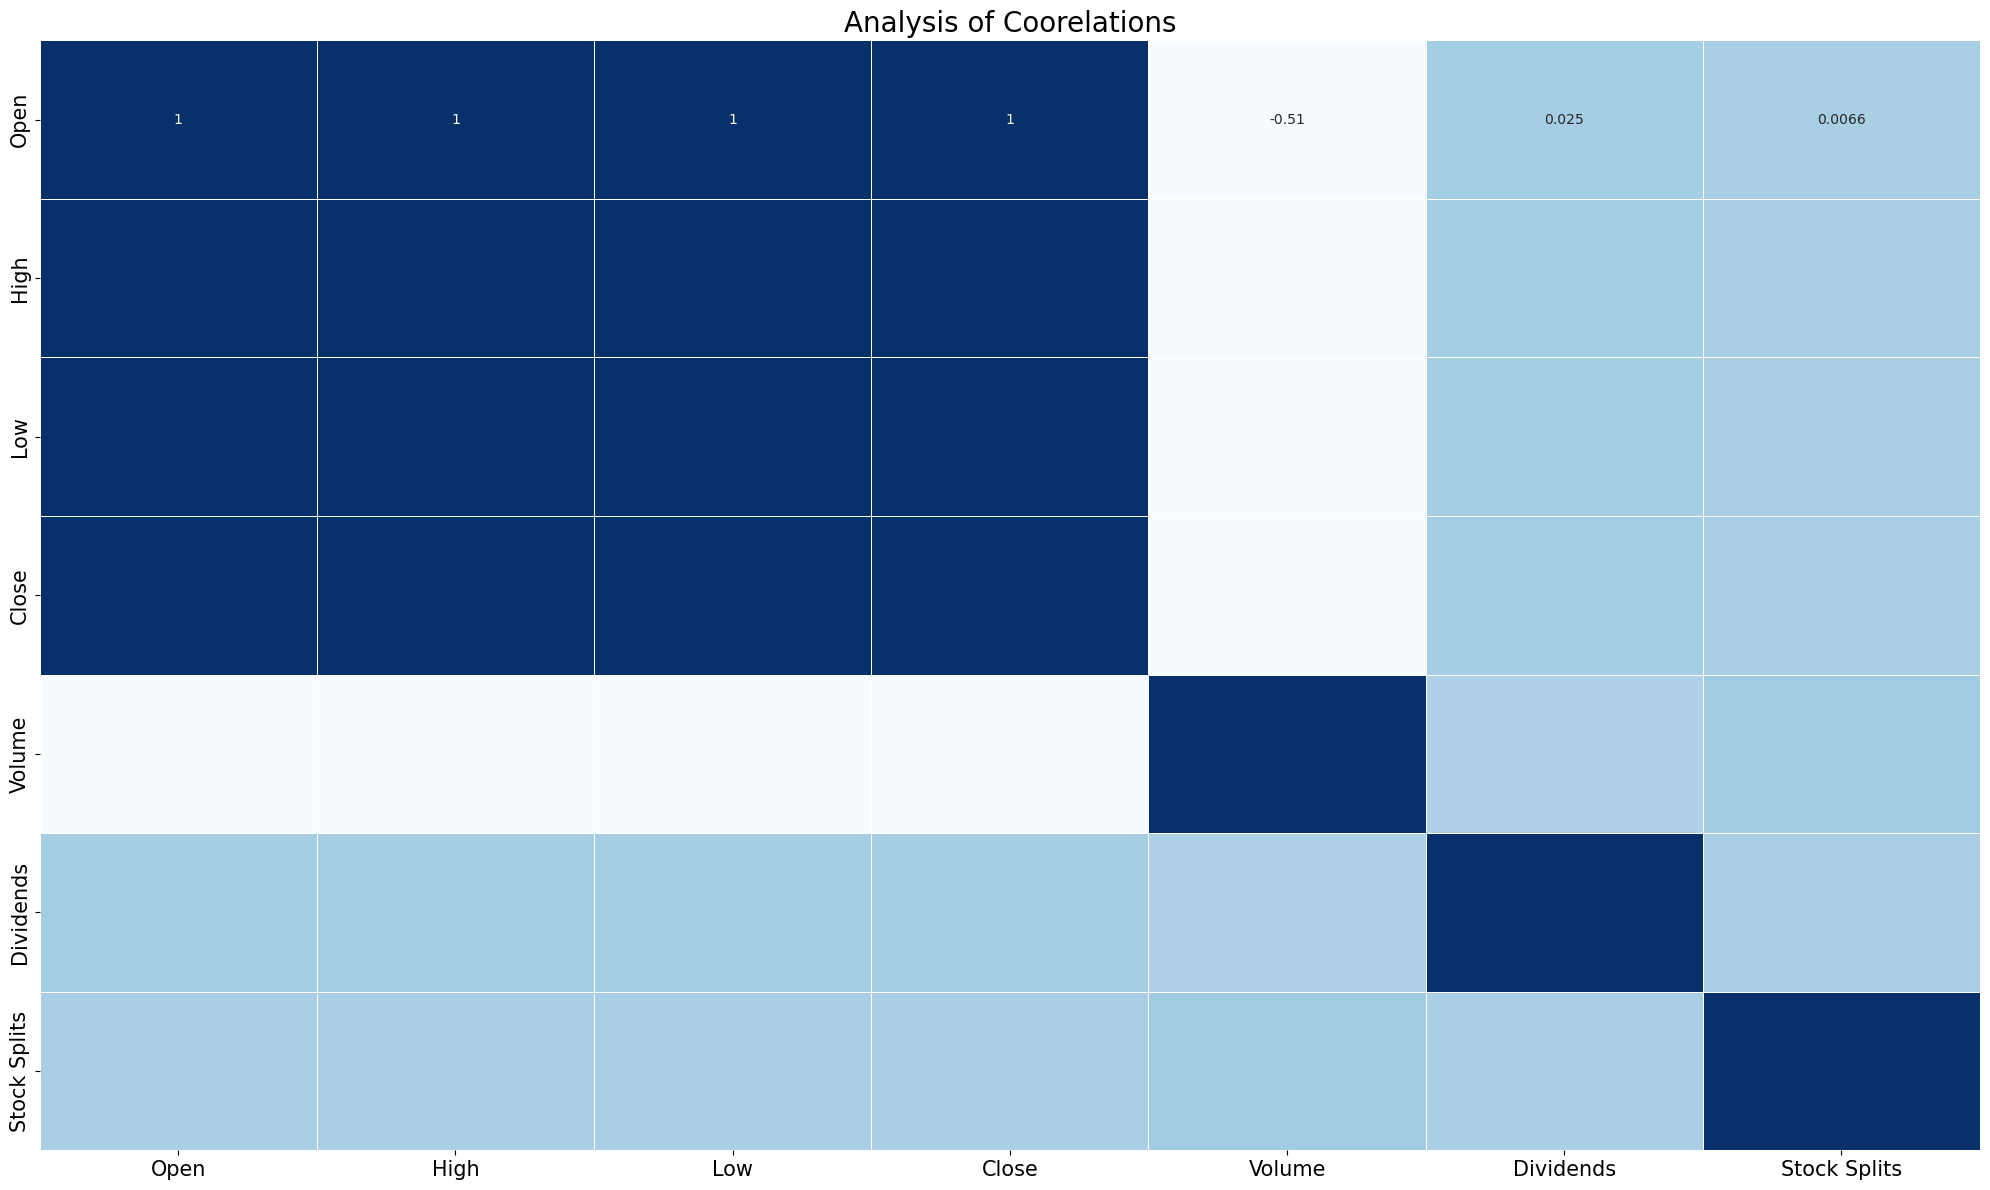

In [12]:
plt.figure(figsize=(20,12))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues', 
            linewidths=.6 , cbar = False)
plt.title('Analysis of Coorelations', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.tight_layout()
plt.show()

In [13]:
columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']

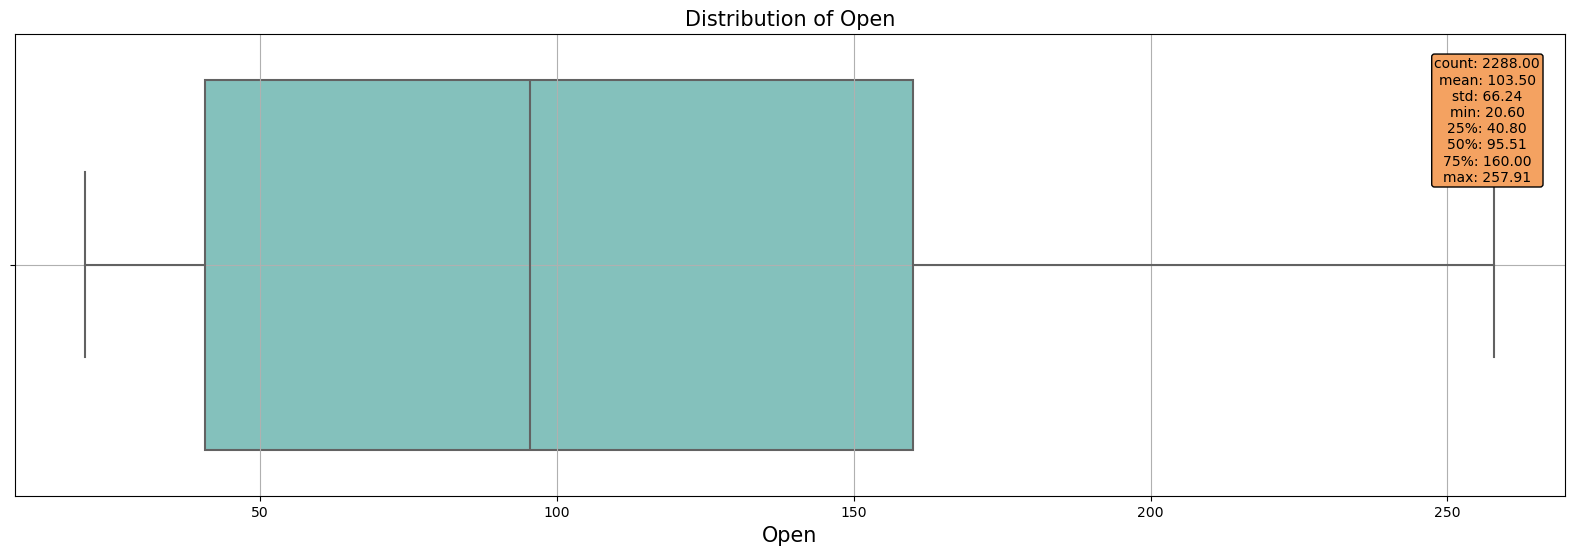

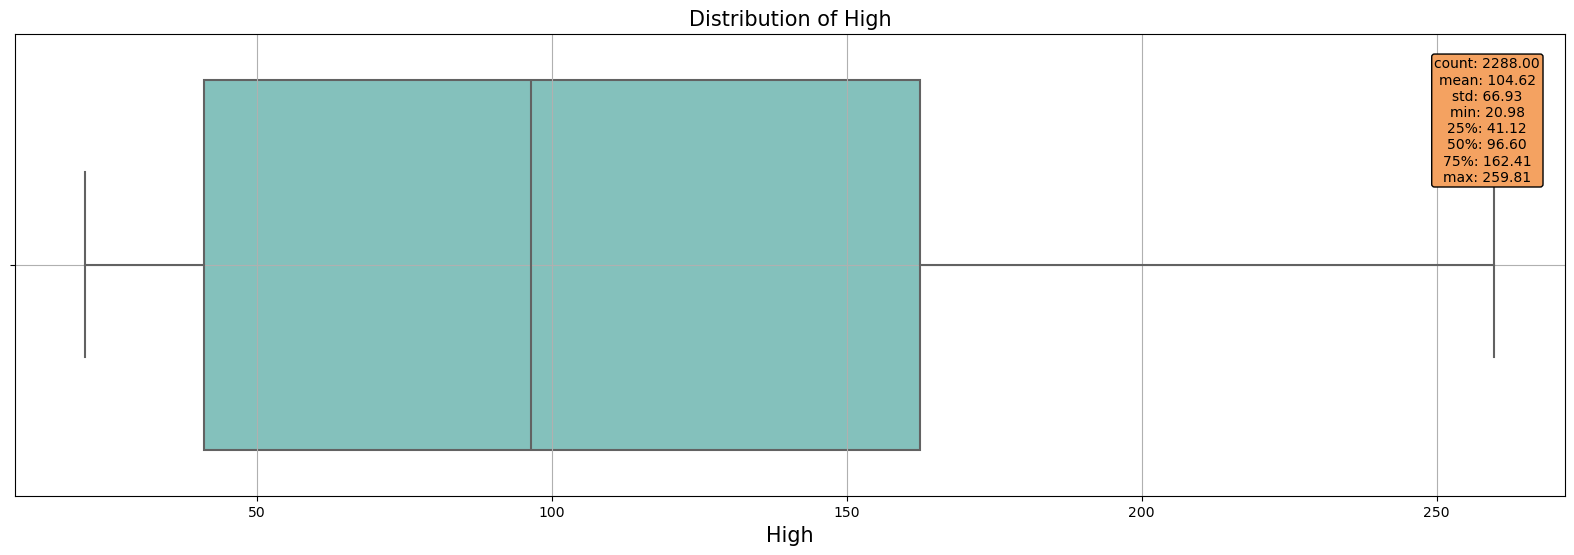

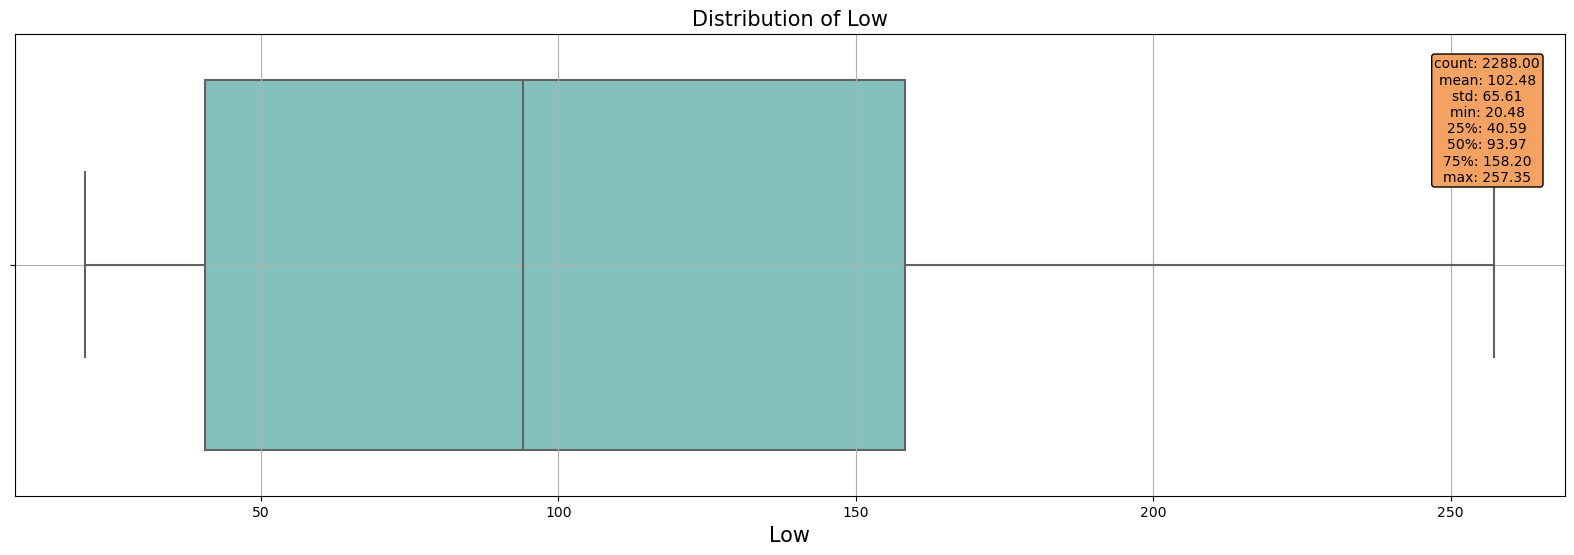

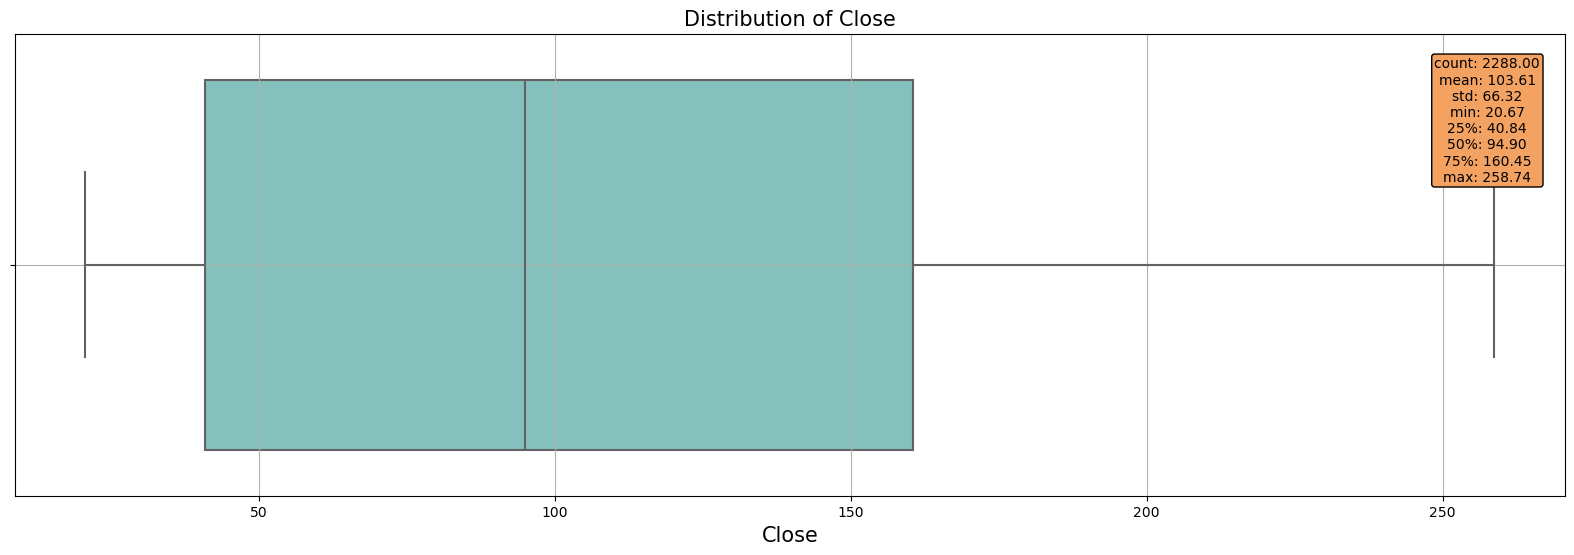

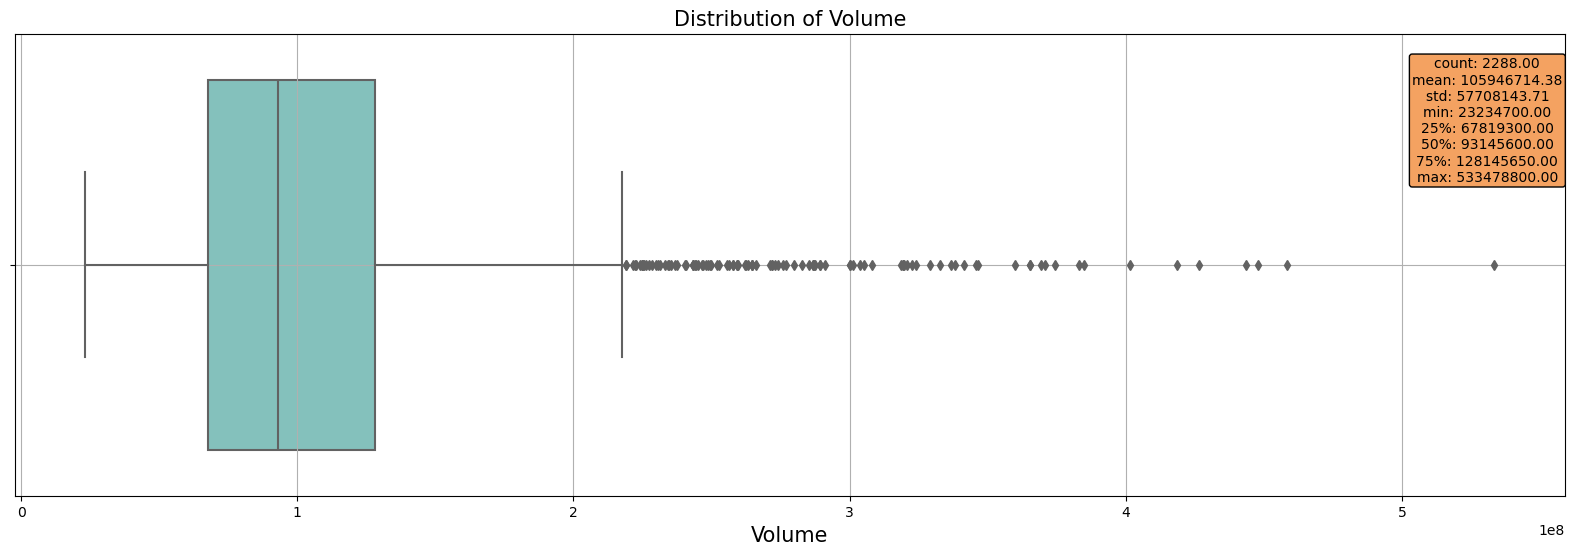

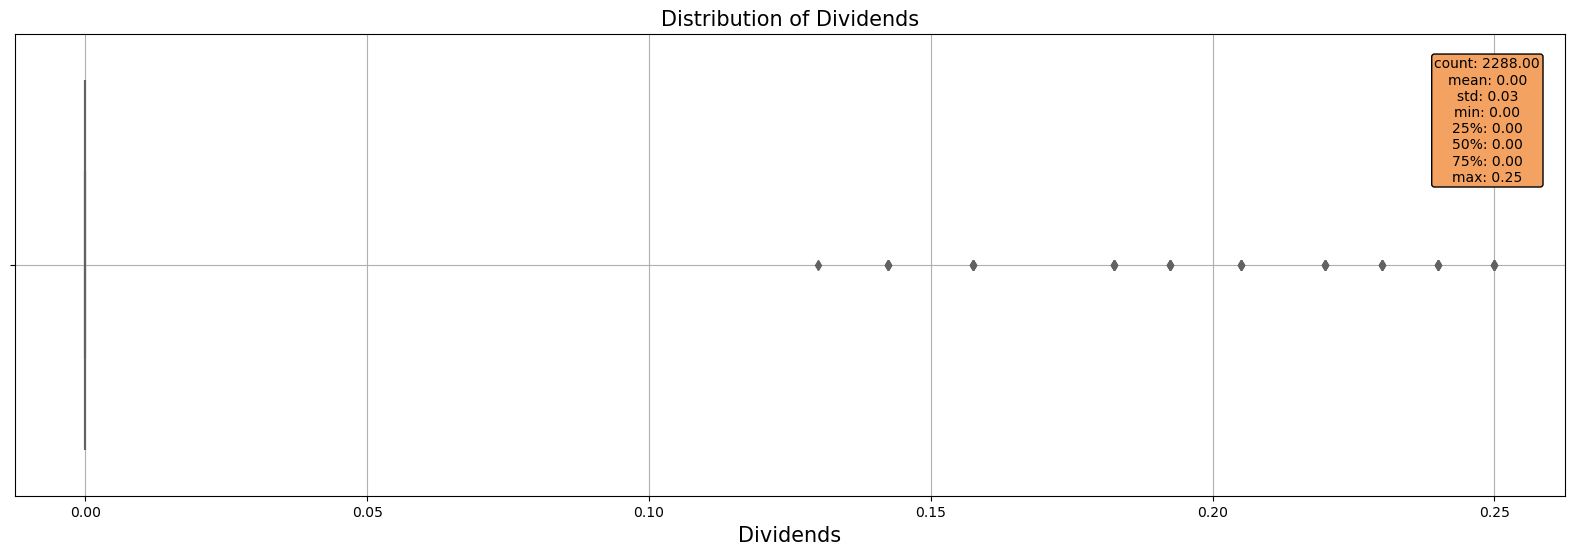

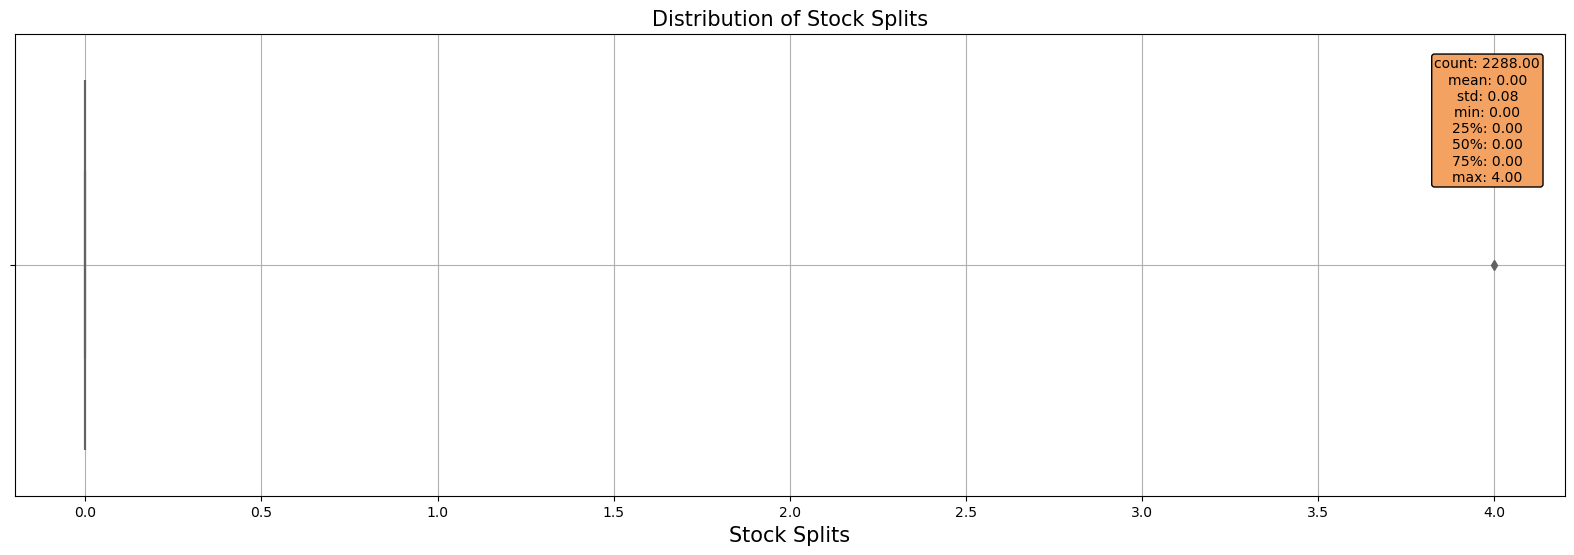

In [14]:
palette = "GnBu" 
for column in columns:
    plt.figure(figsize=(20,6))
    sns.boxplot(x=df[column], palette=palette)
    plt.title(f'Distribution of {column}', fontsize=15)
    plt.xlabel(column, fontsize=15)
    stats = df[column].describe()
    stats_text = "\n".join([f'{key}: {value:.2f}' for key, value in stats.items()])
    plt.text(0.95,0.95, stats_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', horizontalalignment='center',
             bbox=dict(boxstyle='round, pad=0.2', edgecolor='black',facecolor='#f4a261'))   
    plt.grid(True)
    plt.show()

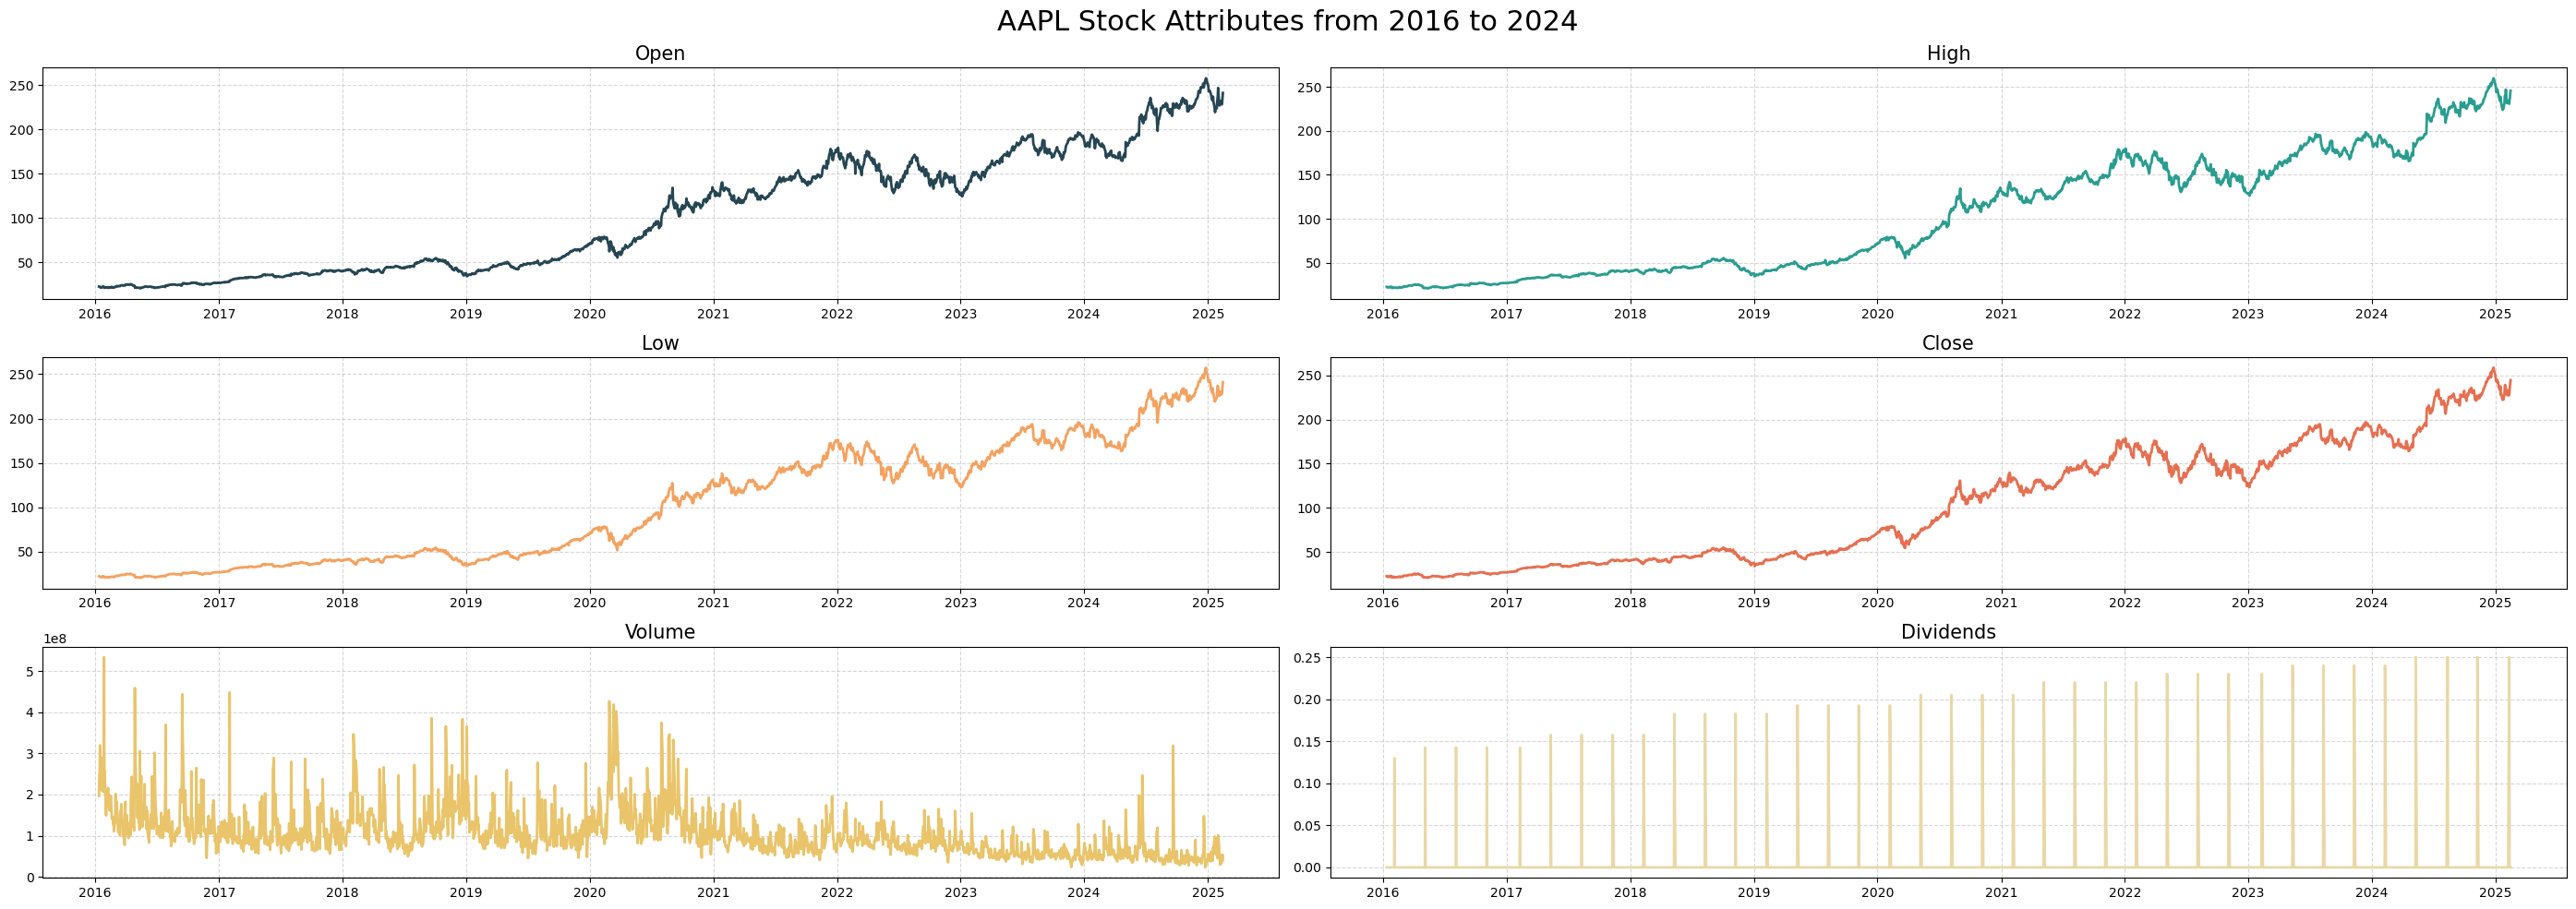

In [15]:
x = df.index
colors = ['#264653', '#2a9d8f', '#f4a261', '#e76f51','#e9c46a', '#e9d8a6']
plt.figure(figsize=(28,10))
plt.subplot(3,2,1)
plt.plot(x, df['Open'], color=colors[0], linewidth=2)
plt.title('Open', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3,2,2)
plt.plot(x,df['High'], color=colors[1], linewidth=2)
plt.title('High', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3,2,3)
plt.plot(x, df['Low'], color=colors[2], linewidth=2)
plt.title('Low', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3,2,4)
plt.plot(x, df['Close'], color=colors[3], linewidth=2)
plt.title('Close', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 5)
plt.plot(x, df['Volume'], color=colors[4], linewidth=2)
plt.title('Volume', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.subplot(3, 2, 6)
plt.plot(x, df['Dividends'], color=colors[5], linewidth=2)
plt.title('Dividends', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.suptitle(f'{COMPANY_NAME} Stock Attributes from 2016 to 2024', fontsize=22, y=0.98)
plt.tight_layout()
plt.show()

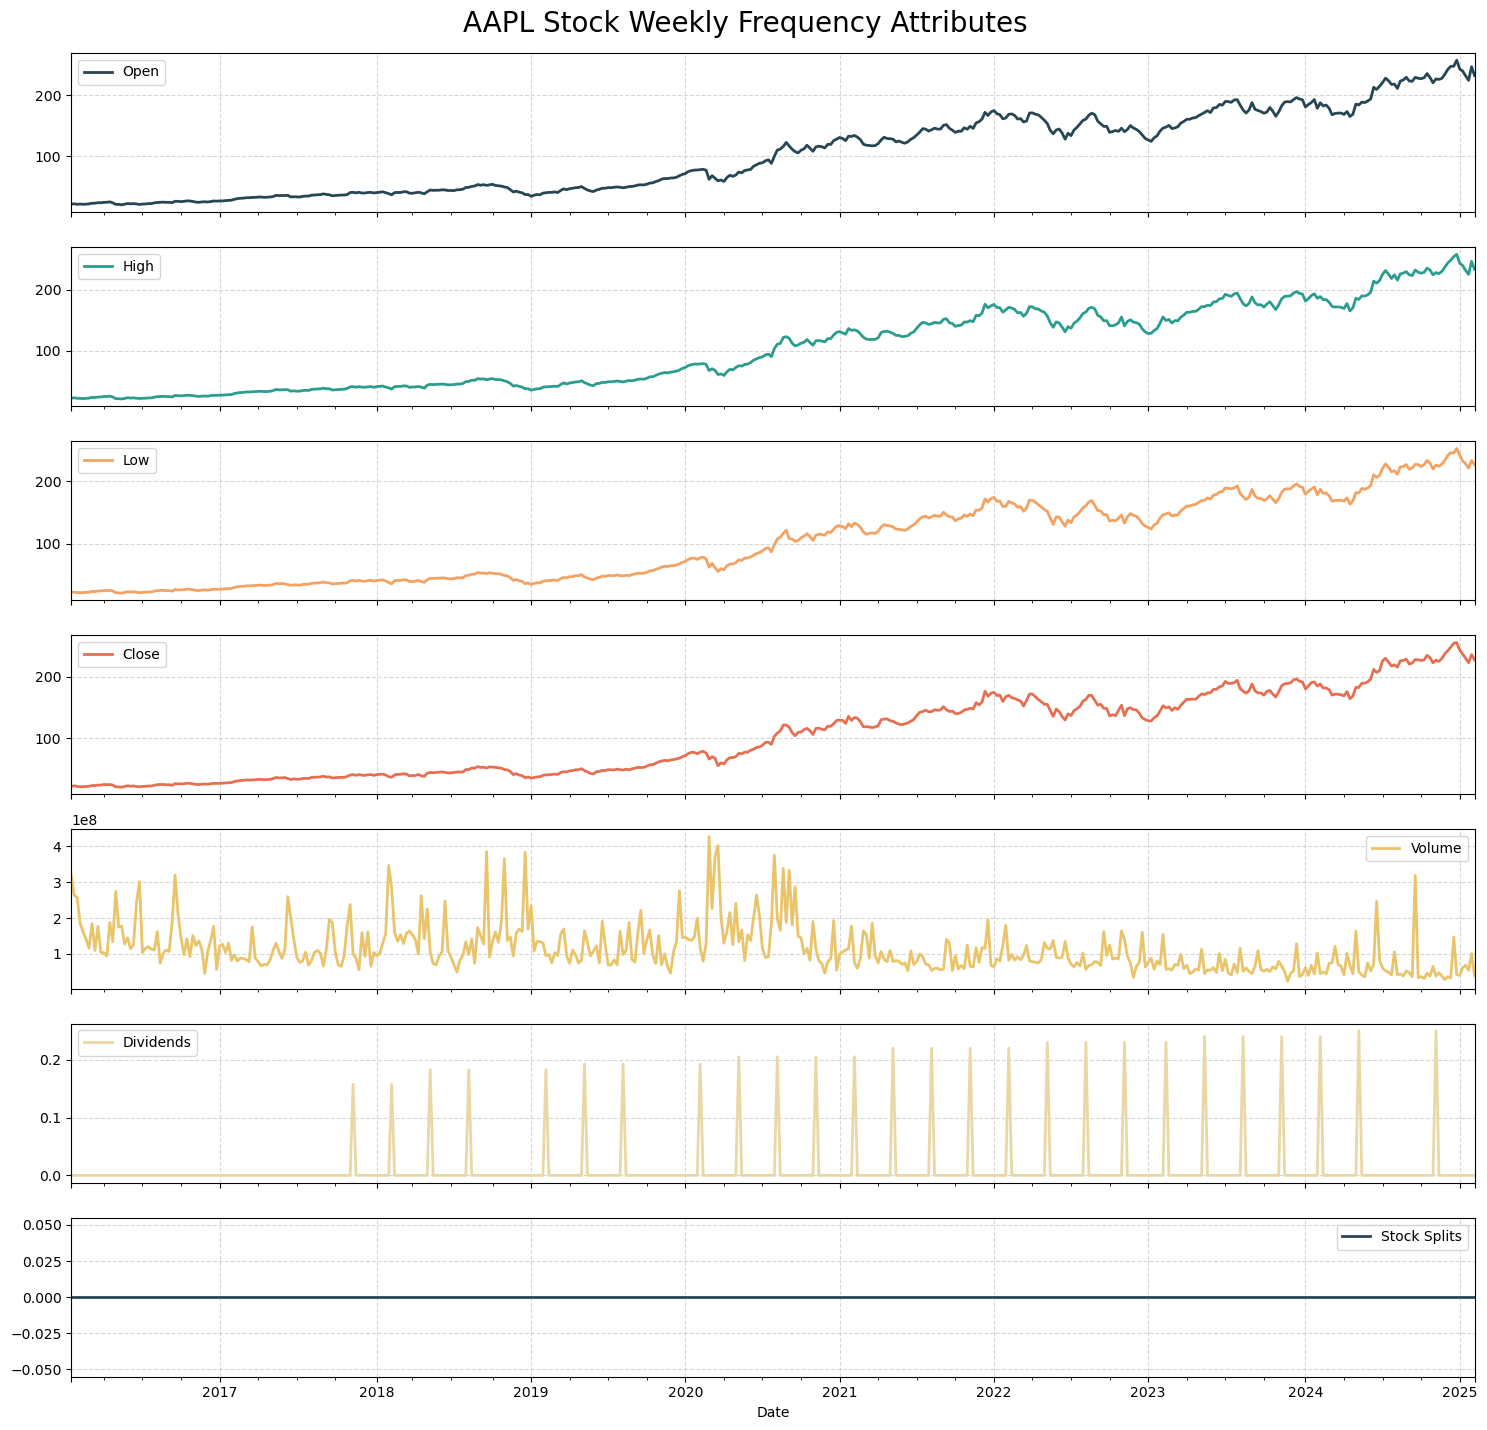

In [16]:
colors = ['#264653', '#2a9d8f', '#f4a261', '#e76f51', '#e9c46a', '#e9d8a6']

df_weekly = df.asfreq('W', method='ffill')
df_weekly.plot(subplots=True, figsize=(15,15), style='-', color=colors, linewidth=2)
plt.suptitle(f"{COMPANY_NAME} Stock Weekly Frequency Attributes", fontsize=20, y=0.95)

for ax in plt.gcf().get_axes():
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_title(ax.get_title(), fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

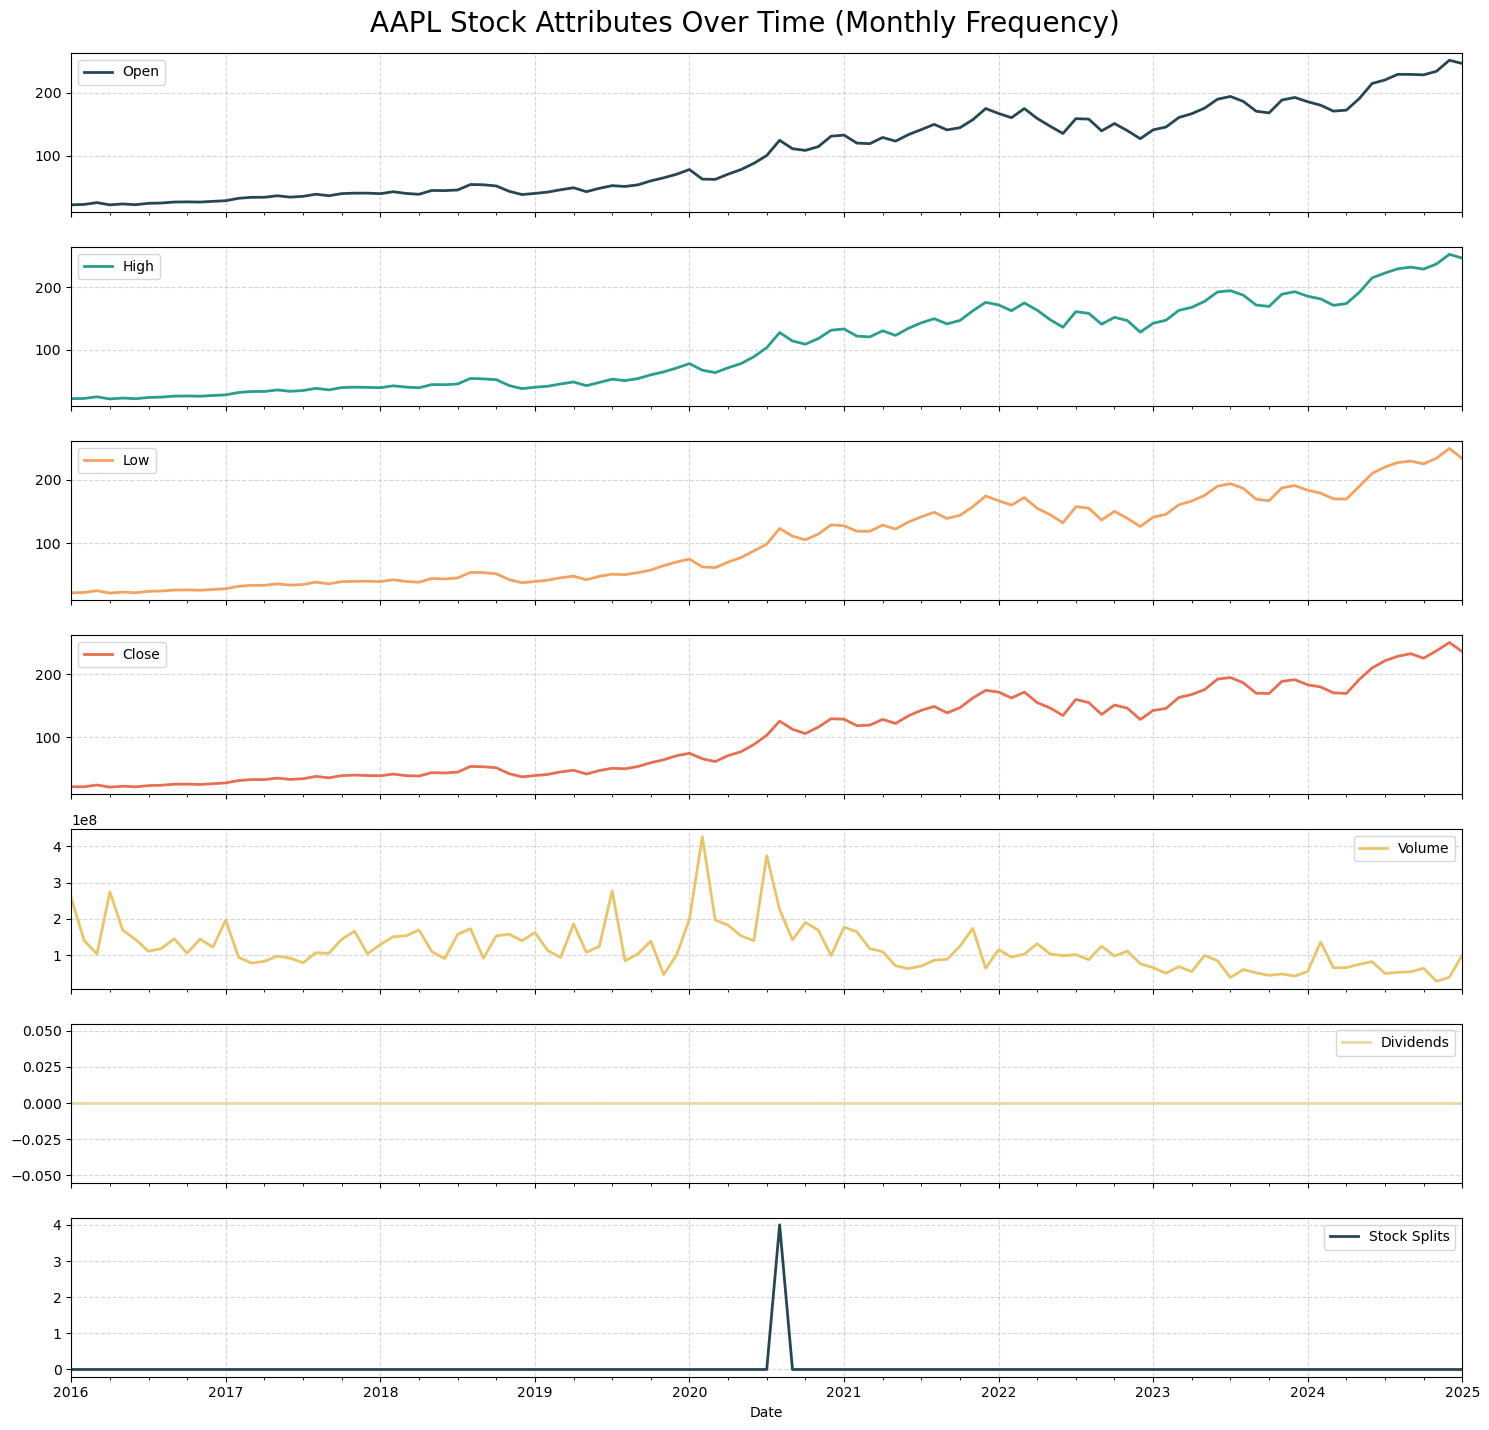

In [17]:
colors = ['#264653', '#2a9d8f', '#f4a261', '#e76f51', '#e9c46a', '#e9d8a6']
df_weekly = df.asfreq('M', method='ffill')
df_weekly.plot(subplots=True, figsize=(15, 15), style='-', color=colors, linewidth=2)
plt.suptitle(f'{COMPANY_NAME} Stock Attributes Over Time (Monthly Frequency)', fontsize=20, y=0.95)
for ax in plt.gcf().get_axes():
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_title(ax.get_title(), fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.show()

In [18]:
# Candlestick char
candle = go.Candlestick(x=df.index, open=df['Open'],
                        high=df['High'], low=df['Low'],
                        close=df['Close'],name='Candlestick',
                        increasing=dict(line=dict(color='#2a9d8f')),
                        decreasing=dict(line=dict(color='#f4a261')))

layout = go.Layout(title=f'{COMPANY_NAME} Candlestick Chart',
                   xaxis=dict(title='Date', color='#2a9d8f'),
                   yaxis=dict(title='Price', color='#2a9d8f',rangemode='normal'),
                   plot_bgcolor='rgba(0,0,0,0)',
                   paper_bgcolor='rgba(255,255,255,0.85)')

fig = go.Figure(data=[candle], layout=layout)

# fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()


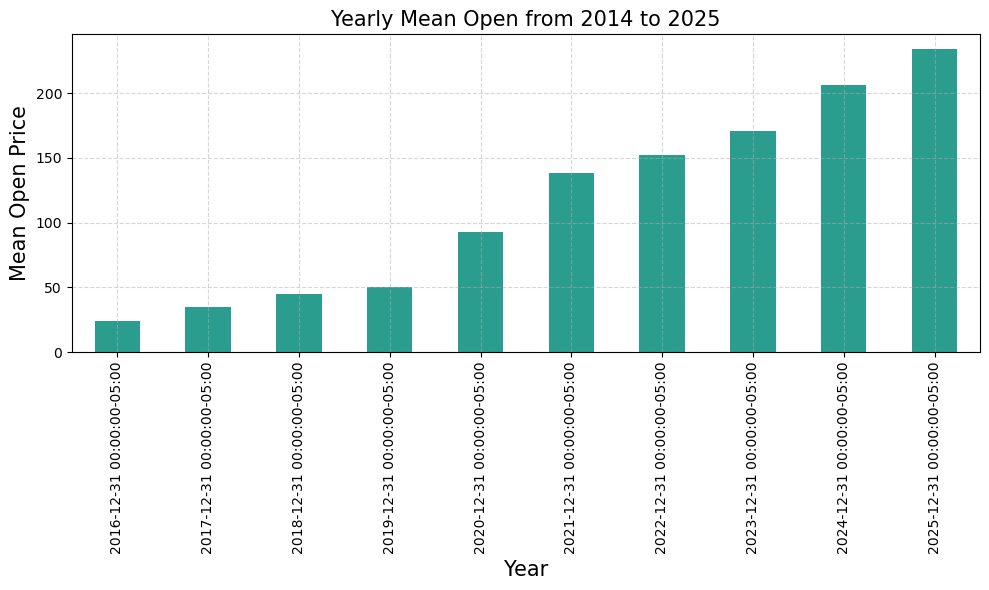

In [19]:
plt.figure(figsize=(10,6))
df['Open'].resample('A').mean().plot(kind='bar', color='#2a9d8f')

plt.title('Yearly Mean Open from 2014 to 2025', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Mean Open Price', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

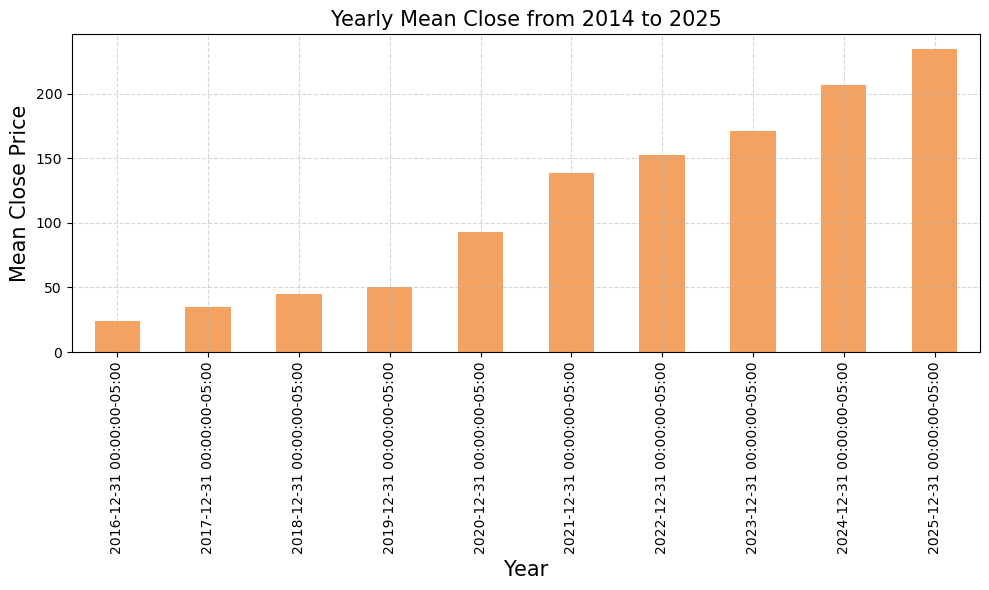

In [20]:
plt.figure(figsize=(10,6))
df['Close'].resample('A').mean().plot(kind='bar', color='#f4a261')

plt.title('Yearly Mean Close from 2014 to 2025', fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Mean Close Price', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

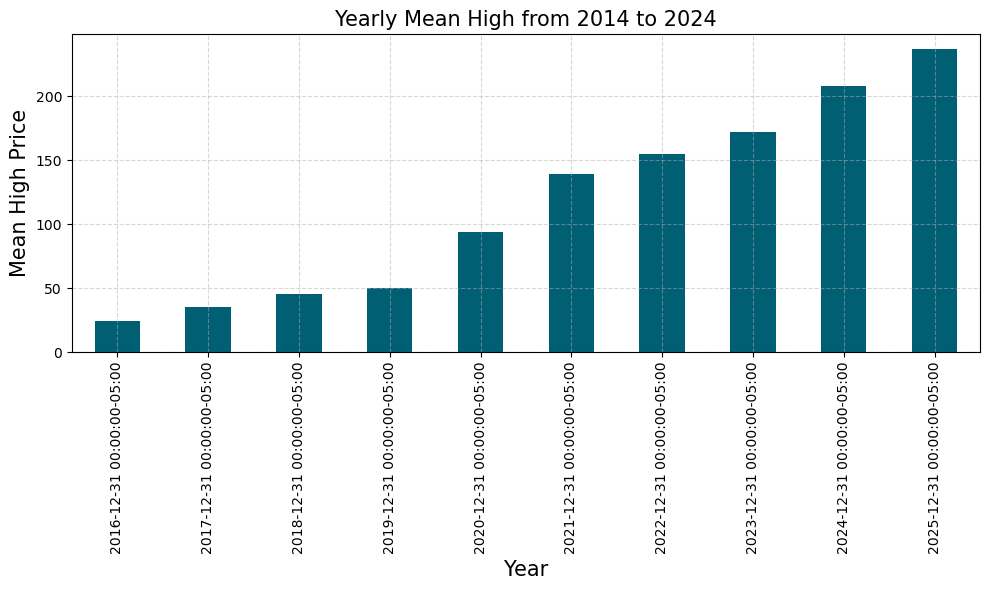

In [21]:
plt.figure(figsize=(10, 6)) 
df['High'].resample('A').mean().plot(kind='bar', color='#005f73')
plt.title('Yearly Mean High from 2014 to 2024', fontsize=15) 
plt.xlabel('Year', fontsize=15)  
plt.ylabel('Mean High Price', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout() 
plt.show()

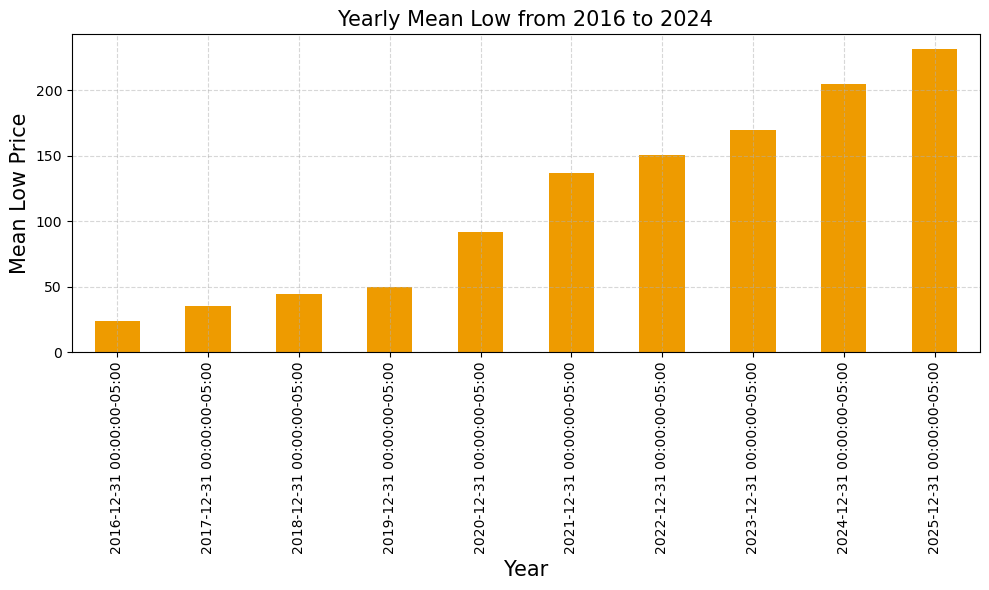

In [22]:
plt.figure(figsize=(10, 6)) 
df['Low'].resample('A').mean().plot(kind='bar', color='#ee9b00')
plt.title('Yearly Mean Low from 2016 to 2024', fontsize=15) 
plt.xlabel('Year', fontsize=15)  
plt.ylabel('Mean Low Price', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout() 
plt.show()

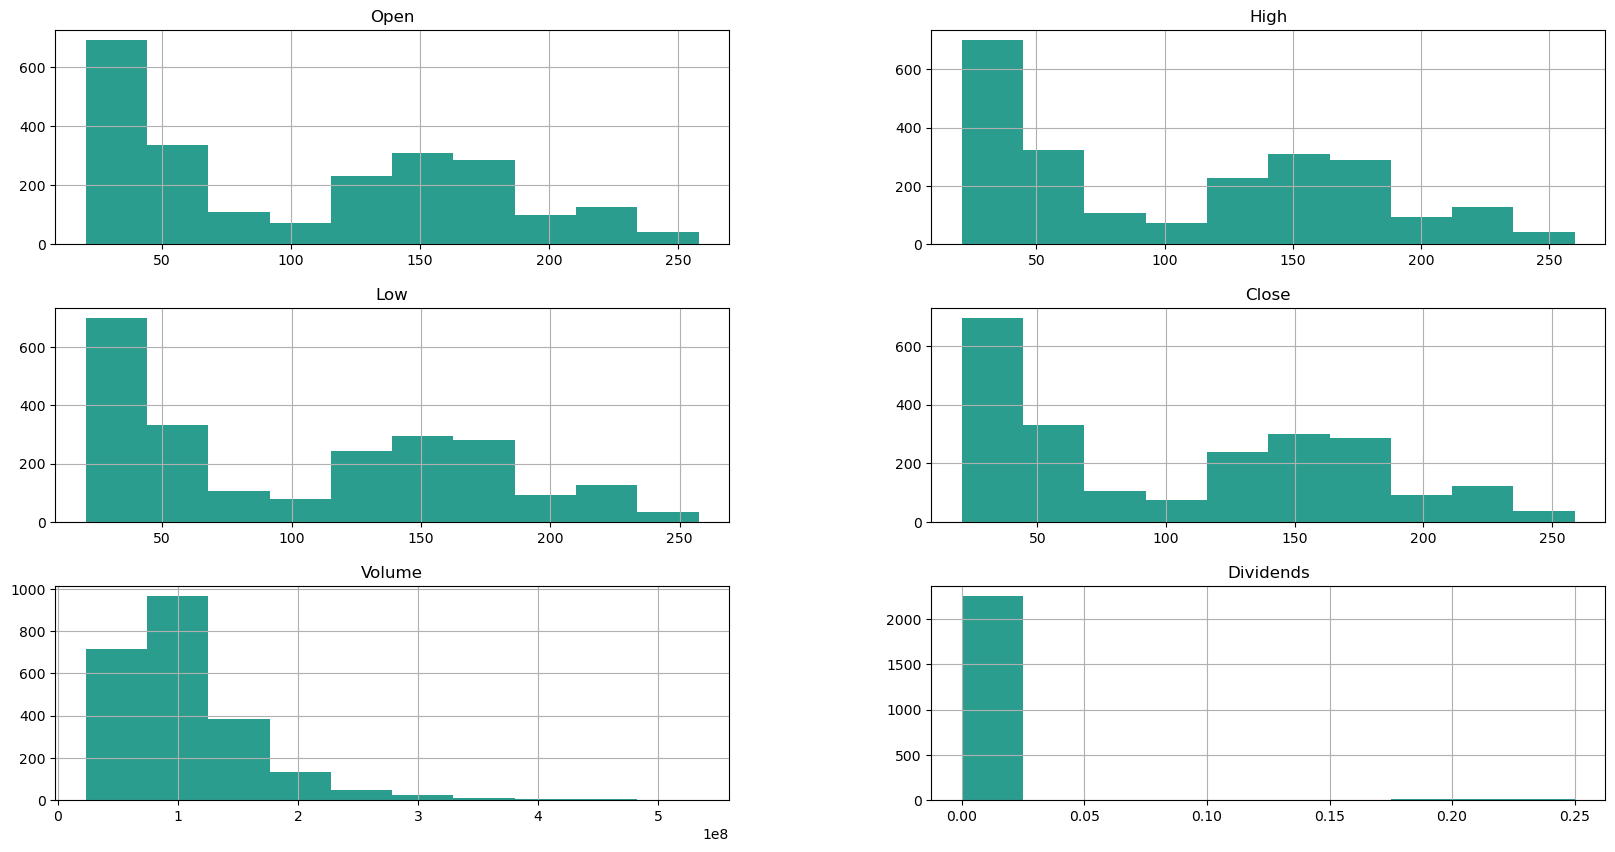

In [23]:
df1 = df.copy()
df1.drop("Stock Splits", axis=1, inplace=True)
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
hist=df1.hist(ax = ax , color= '#2a9d8f')

### SMA (Simple Moving Average)

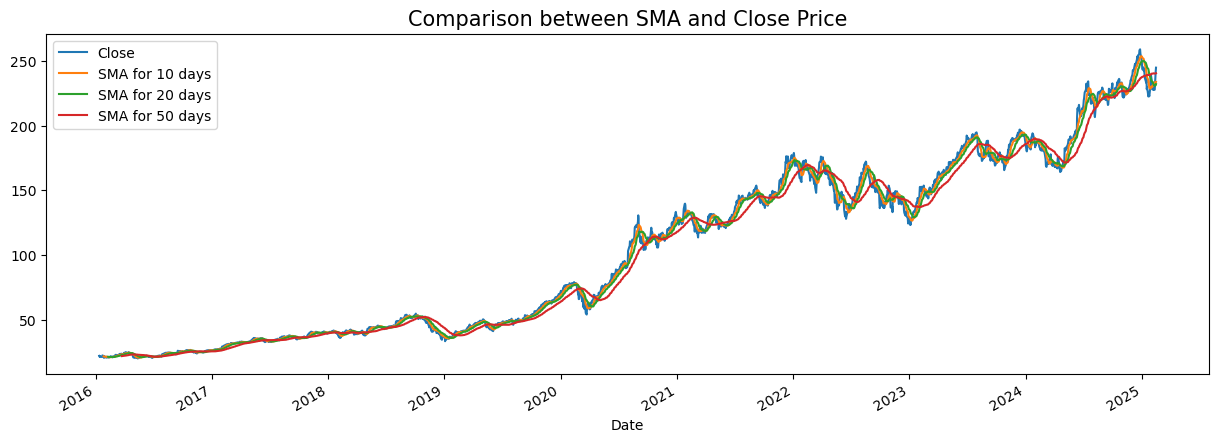

In [24]:
md = [10, 20, 50]

for SMA in md:
    col = f'SMA for {SMA} days'
    df[col] = df['Close'].rolling(SMA).mean()

df[['Close', 'SMA for 10 days', 'SMA for 20 days', 'SMA for 50 days']].plot(figsize=(15,5))
plt.title('Comparison between SMA and Close Price', fontsize=15)
plt.show()

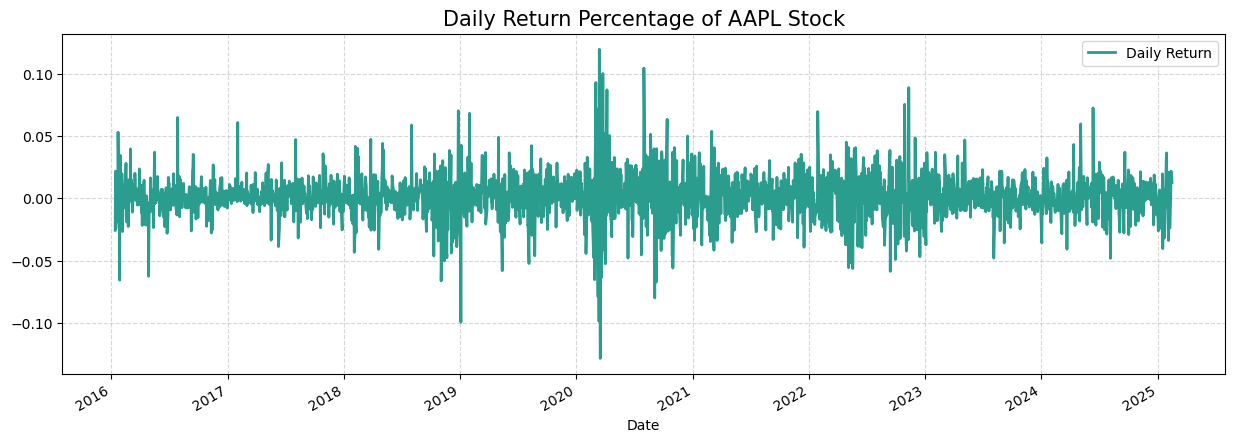

In [25]:
df['Daily Return'] = df['Close'].pct_change()
df['Daily Return'].plot(legend=True, figsize=(15,5), color='#2a9d8f', linewidth=2)
plt.title(f'Daily Return Percentage of {COMPANY_NAME} Stock', fontsize=15)

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### MinMaxScaler

In [26]:
df2 = df.copy(deep=True)

scaler = MinMaxScaler(feature_range=(-1,1))

df2['Open'] = scaler.fit_transform(df2.Open.values.reshape(-1,1))
df2['High'] = scaler.fit_transform(df2.High.values.reshape(-1, 1))
df2['Low'] = scaler.fit_transform(df2.Low.values.reshape(-1, 1))
df2['Close'] = scaler.fit_transform(df2.Close.values.reshape(-1, 1))
df2['Volume'] = scaler.fit_transform(df2.Volume.values.reshape(-1, 1))

df3 = df2[['Open', 'High', 'Low', 'Volume', 'Close']].values

df3.shape

(2288, 5)

### Tensorflow Modeling

#### Preparing Data for time series
We'll utilize the prices from the previous 10 days to forecast the next day's price. Let's create the sequences accordingly.

In [27]:
len(df3) - 11 + 1

2278

In [28]:
T = 11 # sequence length
sequences = []
for index in range(len(df3) - T + 1):
    sequences.append(df3[index: index + T])

sequences = np.array(sequences)
print(sequences.shape)

(2278, 11, 5)


#### Splitting the data

In [29]:
def split_data(sequences):
    df_train, df_test = train_test_split(sequences, 
                                         test_size=0.2, shuffle=False)
    df_val, df_test = train_test_split(df_test,
                                        test_size=0.5, shuffle=False)
    return df_train, df_val, df_test

In [30]:
df_train, df_val, df_test = split_data(sequences)
print('Train shape:', df_train.shape,'Validation shape:', df_val.shape,
      'Test shape:', df_test.shape)

Train shape: (1822, 11, 5) Validation shape: (228, 11, 5) Test shape: (228, 11, 5)


In [31]:
X_train = df_train[:,:-1,:]
Y_train = df_train[:, -1, -1]

X_valid = df_val[:,:-1,:]
Y_valid = df_val[:, -1, -1]

X_test = df_test[:,:-1,:]
Y_test = df_test[:, -1, -1]

#### Defining Model

In [32]:
K = 1
D = df3.shape[1]
T = 10

In [33]:
df3.shape[1]

5

In [34]:
i = Input(shape=(T,D))
x = LSTM(64, return_sequences=True)(i)
x = LSTM(128, return_sequences=False)(x)
# x = LSTM(32, return_sequences=False)(x)
x = Dense(50)(x)
x = Dense(K)(x)

model = Model(i,x)

In [35]:
model.compile(
    loss='mean_squared_error',
    optimizer='adam',
    metrics=['accuracy']
)

print('Training Model')
r = model.fit(
    X_train,
    Y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_valid, Y_valid)
)

Training Model
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.0000e+00 - loss: 0.1096 - val_accuracy: 0.0000e+00 - val_loss: 0.0023
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0000e+00 - loss: 0.0013 - val_accuracy: 0.0000e+00 - val_loss: 0.0016
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 9.6424e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0029
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0000e+00 - loss: 8.6336e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0023
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0000e+00 - loss: 9.0660e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0024
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0000e+00 - loss: 8.2203e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0045
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.0000e+00 - loss: 8.3441e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0030
Epoch 8/50
57/57 ━━━━━━━

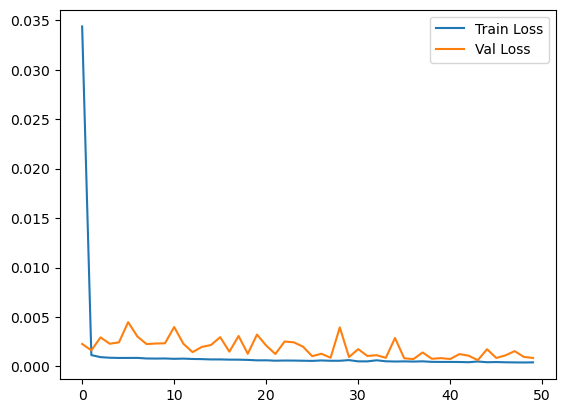

In [36]:
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Val Loss')
plt.legend()

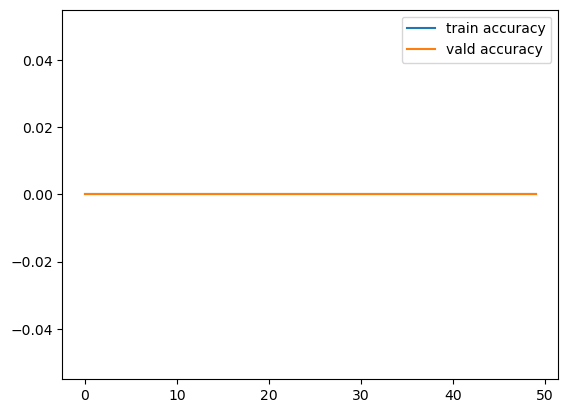

In [37]:
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='vald accuracy')
plt.legend()

In [38]:
Y_pred = model.predict(X_test)

test_loss = model.evaluate(X_test, Y_test)
print('Test Loss:', test_loss)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0015 - loss: 0.0033     
Test Loss: [0.004709881264716387, 0.004385964944958687]


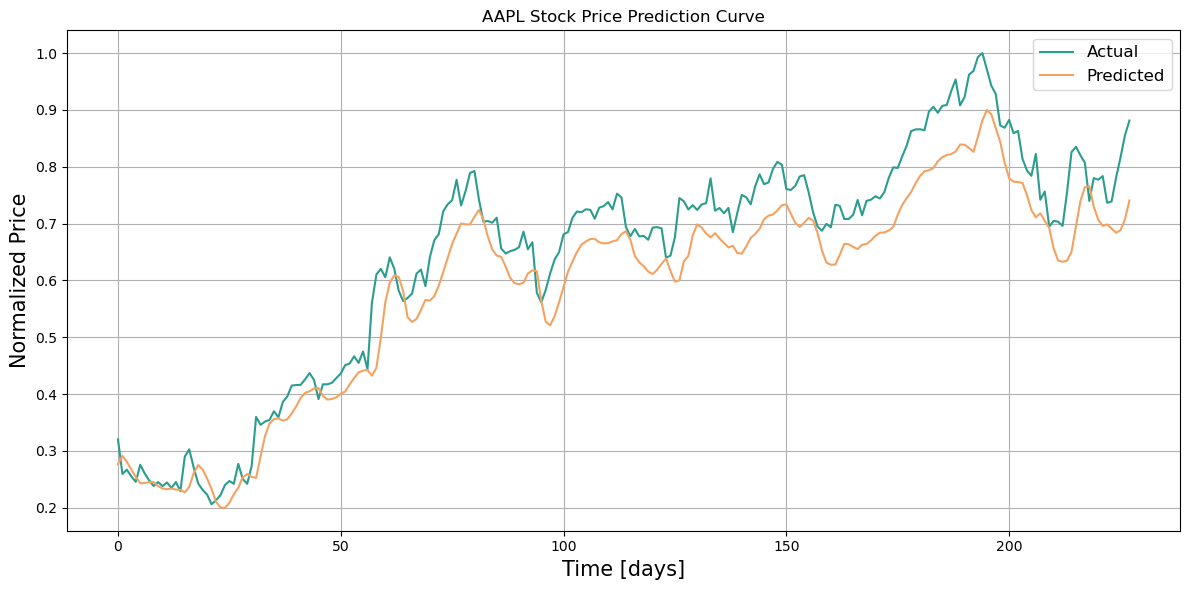

In [39]:
plt.figure(figsize=(12,6))
idx = 0
plt.plot(Y_test, color='#2a9d8f', label='Actual')
plt.plot(Y_pred, color='#f4a261', label='Predicted')
plt.xlabel('Time [days]', fontsize=15)
plt.ylabel('Normalized Price', fontsize=15)
plt.title(f'{COMPANY_NAME} Stock Price Prediction Curve')
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 10, 64)         │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         6,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 369,713 (1.41 MB)

 Trainable params: 123,237 (481.39 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 246,476 (962.80 KB)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


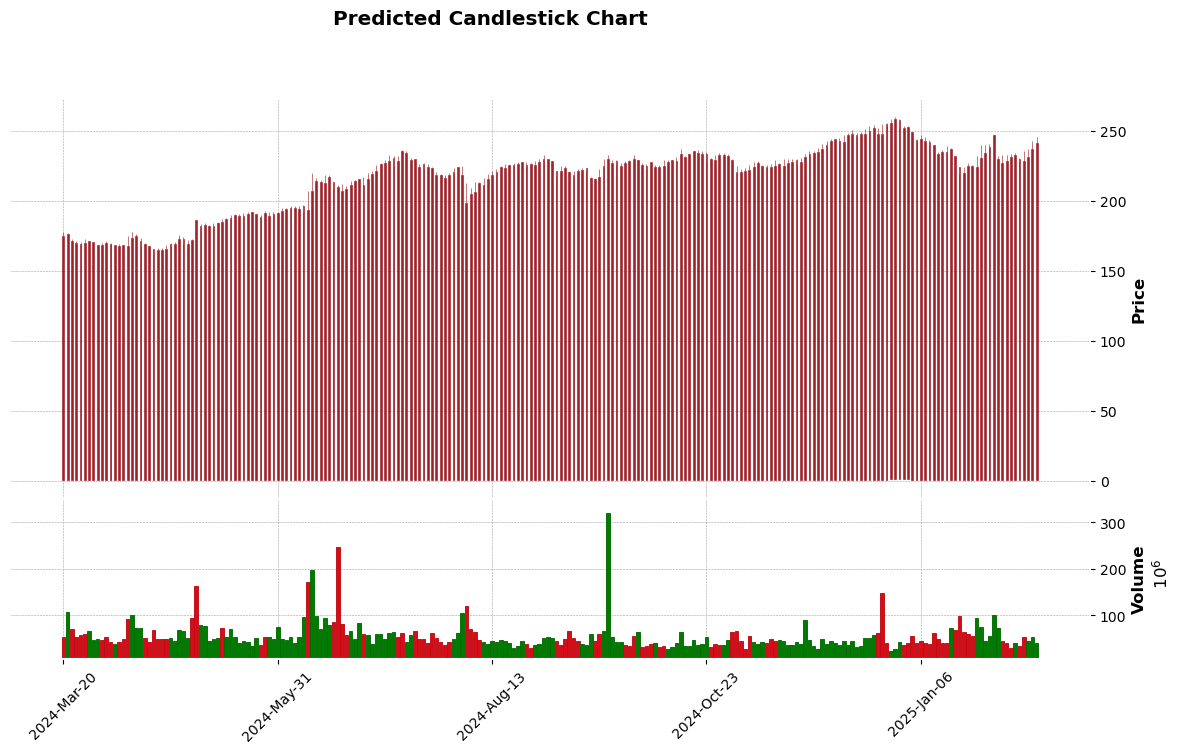

In [41]:
predicted_prices = model.predict(X_test)
df_pred = df.iloc[-len(predicted_prices):].copy()
df_pred['Predicted Close'] = predicted_prices
df_pred['Open'] = df_pred['Open']  
df_pred['High'] = df_pred['High']
df_pred['Low'] = df_pred['Low']
df_pred['Close'] = df_pred['Predicted Close']  
final_df = df_pred[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

final_df.index = pd.to_datetime(df_pred.index)

mpf.plot(
    final_df,
    type='candle',
    volume=True,
    style='charles',
    title='Predicted Candlestick Chart',
    ylabel = 'Price',
    ylabel_lower = 'Volume',
    figsize=(15,8)
)

In [42]:
df = df.reset_index()

In [43]:
df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace=True)

final_df = df[['Open', 'High', 'Low', 'Close']]

candle = go.Candlestick(x=final_df.index, open=final_df['Open'],
                        high=final_df['High'], low=final_df['Low'],
                        close=final_df['Close'], name='Candlestick',
                        increasing_line_color='#2a9d8f',
                        decreasing_line_color='#f4a261'
)

fig = go.Figure([candle])

fig.update_layout(
    title='Predicted Candlestick Chart',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False,
    template='plotly_white',
    height=600,
    width=1000
)

fig.show()

In [44]:
latest_preds = []
last_seq = X_test[:-1]

for i in range(10):
    prediction = model.predict(last_seq)
    latest_preds.append(prediction)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [45]:
df = df.reset_index()

In [46]:
predicted_data_next = np.array(latest_preds).reshape(-1,5)
last_date = df['Date'].max()

next_10_days = [last_date + timedelta(days=i) for i in range(1,11)]

for i, feature_name in enumerate(['Open','High','Low','Volume','Close']):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=next_10_days,
        y=predicted_data_next[:,i],
        mode='lines+markers',
        name=f'Predicted {feature_name.capitalize()} Prices',
        line=dict(color='#f4a261'),
        marker=dict(color='#f4a261')
    ))

    fig.update_layout(
        title=f'Predicted {feature_name.capitalize()} Prices for the next 10 days',
        xaxis_title='Date',
        yaxis_title=f'{feature_name.capitalize()} Price',
        plot_bgcolor='White'
    )
    fig.show()